In [1]:
from alntk.alignment import import_from_fasta, get_unaligned_seqs, get_compact_alignment, write_to_fasta
from alntk.plotting import default_plot_style

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
color_cycle = default_plot_style()
data_folder = '../data/'

In [3]:
new_aln_descs, new_aln_seqs = import_from_fasta(data_folder + 'new_aln.faa')
v, i, c = np.unique(new_aln_descs, return_index=True, return_counts=True)
unique_mask = np.where(c == 1)[0]
new_aln_seqs = new_aln_seqs[unique_mask]
new_aln_descs = new_aln_descs[unique_mask]
# Let us set a fixed seed for reproducibility
np.random.seed(42)
subsample_mask = np.random.randint(0, len(new_aln_descs), size=10_000)
subaln_seqs = new_aln_seqs[subsample_mask]
subaln_descs = new_aln_descs[subsample_mask]

# PCA

We have many options. We could:

1. trim and use the mostly trimmed alignment to compute the PCA and project all the iterations over it
2. trim and use the least trimmed alignment to compute the PCA and project all the iterations over it

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

## Option 1: Trim and use least trimmed on entire alignment

Option 1 seems to yield to a situation in which there is a strong spurious signal.

In [67]:
d_0, s_0 = subaln_descs, subaln_seqs
dels_list = []
for i in range(5):
    d_f, s_f, g_f = get_compact_alignment(d_0, s_0, .95, return_gappy_pos=True)
    d_0, s_0 = d_f, s_f
    dels_list.append(g_f)

In [68]:
s_0 = subaln_seqs.copy()
for dels in dels_list:
    s_0 = np.delete(s_0, dels, axis=1)

In [69]:
ohe = OneHotEncoder(handle_unknown='ignore')
s0_ohe = ohe.fit_transform(s_0)
pca = PCA(n_components=2, svd_solver='arpack')
pca.fit(s0_ohe)
s0_pca = pca.transform(s0_ohe)

In [70]:
sf_ohe = ohe.transform(s_f)
sf_pca = pca.transform(sf_ohe)

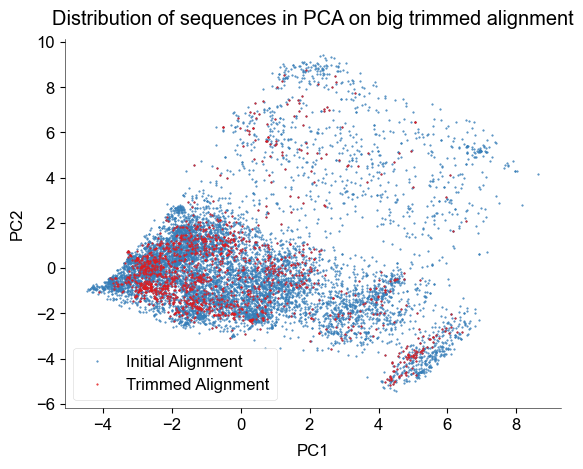

In [71]:
plt.figure()
plt.title('Distribution of sequences in PCA on big trimmed alignment')
plt.plot(s0_pca[:, 0], s0_pca[:, 1], '.', ms=1, label='Initial Alignment')
plt.plot(sf_pca[:, 0], sf_pca[:, 1], '.', ms=1, label='Trimmed Alignment')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [80]:
for i, a in enumerate([''.join(s) for s in s_0]):
    print(a)
    if i==10: break

LLLLAAPATLAAAKIAGPPACGKPQHLNRIVGGEDSTDAEWPWLVSIQKN----GTHYCAGSLLTNHWVLTAAHCFKGHLNKPALFSVLLGAWQLG-NPGPRSQEVGIAWVQSHPVYSW-KEGAHADIALVRLEHAIQFSERILPIC-LPDSS--VHLLPD-TNCWIAGWG-SIH------------------------------------------------------------------------------------------------------------------
--------SLGIYVVSLSSTSVLADVSARIINGKEATDGNWPFMAALVSRNVAYDGQFCGASFIGERYVLTAAHCVEGNSS--EDLDVVIGVSNLS-SSQAAQHRYAVENIYVHQYYNS--VATGSDIAIIELVEK--PSE--SVV-NLVDGYTRGNLNDG-QMLTVMGWGDQDA---SDGY-SSKSELYQVNVPLVNQYQCNSVPYYYSFIGNDAFCAGYSDGGYDSCQGDSGGPIVVSTN-GVYEQLGIVSWGE--GCALADAYGVYTNISYFDDWIDEQ-------
------------------CGVPDVKPQTKIVNGQVALNNSWPWMVAMMID----NSFTCGGSIIAPDWILTAAHCVEDVK-DIRKYKFIYGTNNLN-DPQTESNTAFASKIYMHPDYFS--TVIYNDIALIKLTKKIKFSKKVKPIC-LPNTVKLDEIEK--KIVVATGWGMTNWT------ADVSKLLLQASLVIKNEEGCD-------YSRYNNYCALGLSNDSNICQGDSGGPLQYFKN-GKWFVYGLSSFTTSVSCINT-ELSYFTTVPFYLEWIKRVVSGKPSQ
-----------------------------------------PWQAALFKG----DRFICGGTLVDRNWVLTAAHCHVP-----GSISMRLGGQSHK-DSGGTPQWRRSVKVFRYPRYNE--STKDGDLML

I think that by using the full alignment and trimming it we get weird results because we are doing weird trimmings in sequences that are must not be trimmed... actually then we are trimming the places where only they have amino acids so I get it that it yields to weird results.

## Option 2: Trim and use most trimmed on entire alignment

In [72]:
d_0, s_0 = subaln_descs, subaln_seqs
dels_list = []
for i in range(5):
    d_f, s_f, g_f = get_compact_alignment(d_0, s_0, .95, return_gappy_pos=True)
    d_0, s_0 = d_f, s_f
    dels_list.append(g_f)

In [73]:
s_0 = subaln_seqs.copy()
for dels in dels_list:
    s_0 = np.delete(s_0, dels, axis=1)

In [74]:
ohe = OneHotEncoder(handle_unknown='ignore')
sf_ohe = ohe.fit_transform(s_f)
pca = PCA(n_components=2, svd_solver='arpack')
pca.fit(sf_ohe)
sf_pca = pca.transform(sf_ohe)

In [75]:
s0_ohe = ohe.transform(s_0)
s0_pca = pca.transform(s0_ohe)

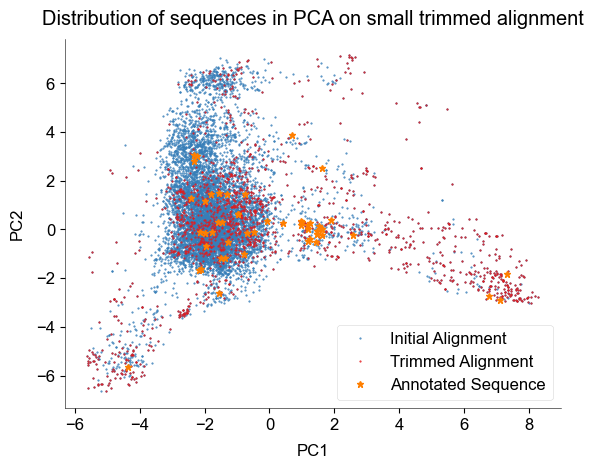

In [98]:
plt.figure()
plt.title('Distribution of sequences in PCA on small trimmed alignment')
plt.plot(s0_pca[:, 0], s0_pca[:, 1], '.', ms=1, label='Initial Alignment')
plt.plot(sf_pca[:, 0], sf_pca[:, 1], '.', ms=1, label='Trimmed Alignment')
plt.plot(s0_pca[np.char.startswith(subaln_descs, 'sp'), 0], s0_pca[np.char.startswith(subaln_descs, 'sp'), 1], '*', ms=5, label='Annotated Sequence', color='#'+color_cycle[4])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

# Sandbox

In [8]:
for thr_idx, thr in enumerate([0.7, 0.8, 0.9, 0.95, 0.99, 1.]):
    final_aln_descs, final_aln_seqs = get_compact_alignment(subaln_descs, subaln_seqs, thr)
    if thr_idx == 0:
        ohe = OneHotEncoder(handle_unknown='ignore')
        s_ohe = ohe.fit_transform(final_aln_seqs)
        pca = PCA(n_components=2, svd_solver='arpack')
        pca.fit(s_ohe)
        s_pca = pca.transform(s_ohe)
    break

In [5]:
ohe = OneHotEncoder(handle_unknown='ignore')
s_ohe = ohe.fit_transform(subaln_seqs)
pca = PCA(n_components=2, svd_solver='arpack')
pca.fit(s_ohe)
s_pca = pca.transform(s_ohe)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15,11))
for i, gap_thr in enumerate(np.linspace(6000, 10_000, 6)):
    gappy_pos = np.where(np.sum(subaln_seqs == '-', axis=0) > gap_thr)[0]
    mask = np.where(np.sum((subaln_seqs != '-')[:, gappy_pos], axis=1) == 0)[0]
    new_subaln_seqs = subaln_seqs[mask]
    new_subaln_seqs_pca = pca.transform(ohe.transform(new_subaln_seqs))
    axs[i//3][i%3].scatter(s_pca[:, 0], s_pca[:, 1], s=1, alpha=0.2)
    axs[i//3][i%3].scatter(new_subaln_seqs_pca[:, 0], new_subaln_seqs_pca[:, 1], s=1, alpha=1)
    axs[i//3][i%3].title.set_text(f'Threshold at {round(gap_thr)}')
    axs[i//3][i%3].set_xlabel('PC1')
    axs[i//3][i%3].set_ylabel('PC2')
plt.show()